In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import cv2
import os
import re
import math

## Exploratory Data Analysis

### Checking label, label name and image-name in data.csv

Import from data.csv, which consist the image name, corresponding label and label name, name dataframe as mj_df

In [2]:
mj_df = pd.read_csv("data.csv")
print('Shape of data:', mj_df.shape)

display(mj_df.head())

Shape of data: (700, 3)


image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east


It is noted that the "image-name" and "label-name" are with hyphen, change them to underscore to prevent error when calling df.XXX-XXX

In [3]:
mj_df = mj_df.rename(columns=lambda x: re.sub('-', '_', x))

Afterwards, add a new column of image path to mj_df

In [4]:
image_path = os.path.join('images','{}')
mj_df['image_path'] = mj_df['image_name'].apply(lambda x :image_path.format(x))
mj_df.head()

image_name  label    label_name    image_path
0      1.jpg     38  bonus-winter  images\1.jpg
1      2.jpg     26  characters-8  images\2.jpg
2      3.jpg      9        dots-9  images\3.jpg
3      4.jpg     36  bonus-summer  images\4.jpg
4      5.jpg     28   honors-east  images\5.jpg

Check if the data is consistent, including label and label_name

Text(0.5, 0, 'Label_Name')

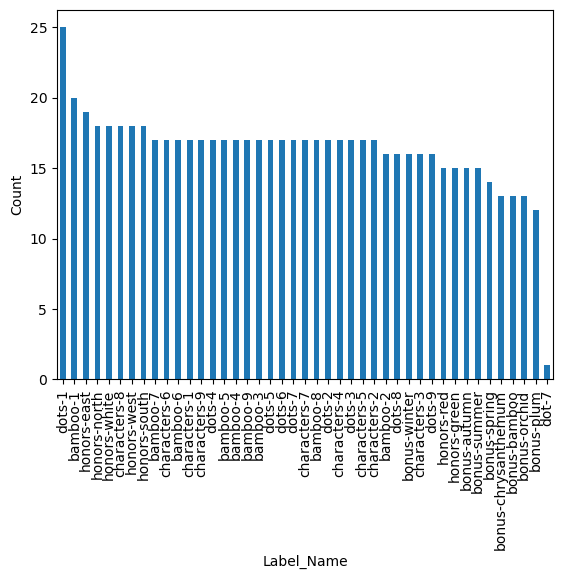

In [5]:
df_barchart = mj_df['label_name'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label_Name",fontsize=10)

It is noted that there is a typo in one of the label_name, instead of "dot-7" it should be "dots-7", replace accordingly

In [6]:
mj_df['label_name'] = mj_df['label_name'].replace({'dot-7': 'dots-7'})

Text(0.5, 0, 'Label_Name')

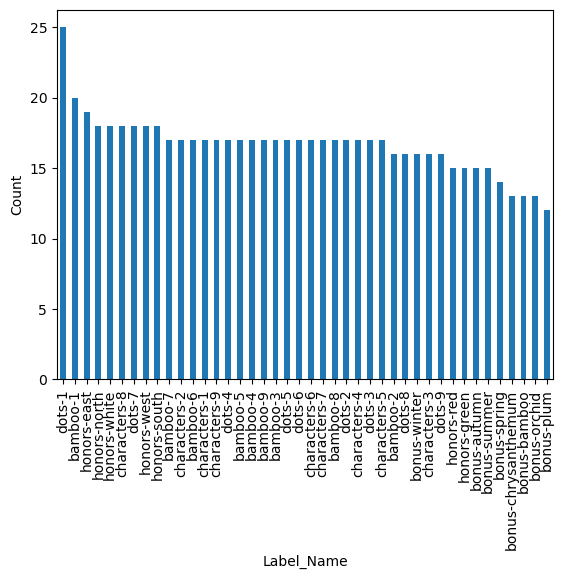

In [7]:
df_barchart = mj_df['label_name'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label_Name",fontsize=10)

Looking good, next check if there's any error for numeric labels.

Text(0.5, 0, 'Label')

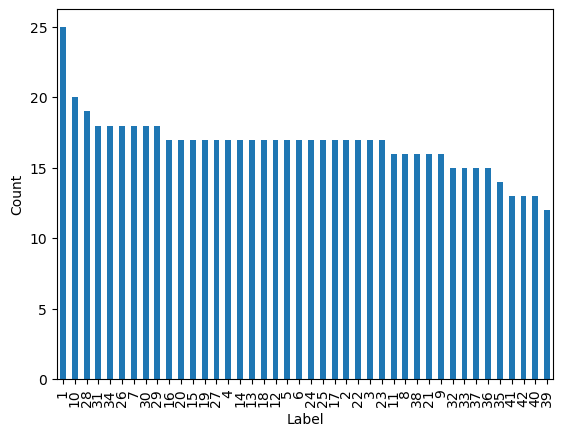

In [8]:
df_barchart = mj_df['label'].value_counts()
df_barchart.plot.bar()
plt.ylabel("Count",fontsize=10)
plt.xlabel("Label",fontsize=10)

It is noted the label starts at 1 instead of 0, subtract 1 from labels to facilitate classification by tensorflow later.

In [9]:
mj_df['label'] -= 1
mj_df.head()
print('mj_df Label starts at:', min(mj_df['label']), 'after subtract.')


mj_df Label starts at: 0 after subtract.


Then check if the label and label_name are unique pair.

In [10]:
mj_df.groupby(['label', 'label_name']).size()

label  label_name         
0      dots-1                 25
1      dots-2                 17
2      dots-3                 17
3      dots-4                 17
4      dots-5                 17
5      dots-6                 17
6      dots-7                 18
7      dots-8                 16
8      dots-9                 16
9      bamboo-1               20
10     bamboo-2               16
11     bamboo-3               17
12     bamboo-4               17
13     bamboo-5               17
14     bamboo-6               17
15     bamboo-7               17
16     bamboo-8               17
17     bamboo-9               17
18     characters-1           17
19     characters-2           17
20     characters-3           16
21     characters-4           17
22     characters-5           17
23     characters-6           17
24     characters-7           17
25     characters-8           18
26     characters-9           17
27     honors-east            19
28     honors-south           18
29     honors-we

The label and label name pairs are unique, set num_classes as unique labels (42 classes)

In [11]:
num_classes = mj_df['label'].nunique()
print(num_classes, 'number of classes')

42 number of classes


### Loading and preprocessing of images

Afterwards, we would like to load the images into a list with cv2, at the same time check the aspect ratio of the photos.
Since data augmentation would be performed, the images shall be in same aspect ratio for image resize.

In [12]:
images= []
for index, row in mj_df[['image_path']].iterrows():
    img = cv2.imread(row[0], cv2.IMREAD_UNCHANGED)
    height, width = img.shape[:2]
    # Save the dimensions to a new column in the DataFrame
    mj_df.loc[index, 'width'] = width
    mj_df.loc[index, 'height'] = height
    if img is not None:
        images.append(img)
#calculate the image aspect ratio
mj_df['ratio'] = mj_df['width']/mj_df['height']

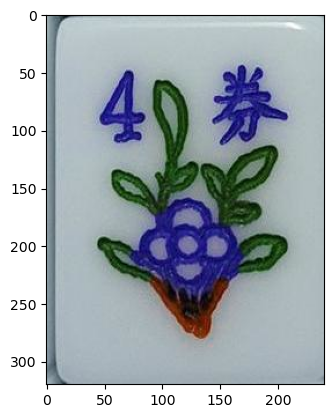

In [13]:
#Display of sample image
plt.imshow(images[0].astype("uint8"))

Most of the images have aspect ratio of 3:4, hence try to find ones that are not 3:4.

In [14]:
mj_df[mj_df['ratio'] != 0.75]

image_name  label    label_name      image_path  width  height     ratio
640    641.jpg     28  honors-south  images\641.jpg  136.0   184.0  0.739130
687    688.jpg     39  bonus-orchid  images\688.jpg   89.0   116.0  0.767241

Noting two of the images don't have a ratio of 0.75, amend to size to allow uniform resize in data augmentation

In [15]:
images[640] = images[640][0:180, 0:135]
mj_df.loc[640, 'width'] = 135
mj_df.loc[640, 'height'] = 180
images[688] = images[688][0:116, 0:87]
mj_df.loc[688, 'width'] = 87
mj_df.loc[688, 'height'] = 116
print('shape of images[640]:',images[640].shape[:2])
print('shape of images[688]:',images[688].shape[:2])
mj_df['ratio'] = mj_df['width']/mj_df['height']

shape of images[640]: (180, 135)
shape of images[688]: (116, 87)


In [16]:
display(mj_df.loc[[640,688]])

image_name  label           label_name      image_path  width  height  \
640    641.jpg     28         honors-south  images\641.jpg  135.0   180.0   
688    689.jpg     40  bonus-chrysanthemum  images\689.jpg   87.0   116.0   

     ratio  
640   0.75  
688   0.75

Since tensor can only take rectangular array, resize the images to 224x224 with cv2.resize

In [17]:
img_height = 224
img_width = 224
num_classes = 42

In [18]:
images_resized = []
for image in images:
    img_resized = cv2.resize(image, dsize=(img_height, img_width), interpolation=cv2.INTER_NEAREST)
    images_resized.append(img_resized)
print('Resized image shape:',images_resized[0].shape)

Resized image shape: (224, 224, 3)


Load the resized images and labels into np.array

In [19]:
img_arr = np.array(images_resized, dtype=object)
label = np.array(mj_df['label'])
print('img_arr shape:',img_arr.shape)
print('label shape:', label.shape)

img_arr shape: (700, 224, 224, 3)
label shape: (700,)


In [20]:
indices = np.arange(label.shape[0])

In [21]:
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=320, stratify=label)
#check size of train set
print('Size of train set:',indices_train.shape)

Size of train set: (560,)


<br>
Since each label has limited number of sample (e.g. for label 38 bonus-plum  there's only 12 samples), it is preferred to use stratified split in dataset. Use StratifiedKFold to separate data into 4 sets for model training.

Train test 1 has a size of (420, 224, 224, 3)
Train test 2 has a size of (420, 224, 224, 3)
Train test 3 has a size of (420, 224, 224, 3)
Train test 4 has a size of (420, 224, 224, 3)


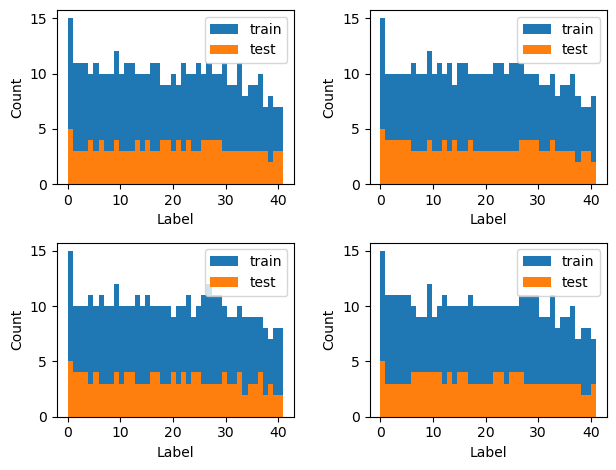

In [22]:
label = np.array(mj_df['label'])
kfold_bar=[]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=320)
fig = plt.figure()
n=0
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=320, stratify=label)
img_train, X_test = img_arr[indices_train], img_arr[indices_test]
label_train, y_test = label[indices_train], label[indices_test]
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    n += 1
    print('Train test', n, 'has a size of', X_train.shape)
    fig.tight_layout()
    plt.subplot(2, 2, n)
    plt.hist(label_train[train_index], label="train", bins = num_classes)
    plt.hist(label_train[val_index], label="test", bins = num_classes)
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.legend(loc=1)

### Visualize images and corresponding label

In [23]:
def display_image(images,labels, num_img):
    for n, (image, label) in enumerate(zip(images[:num_img],labels[:num_img])):
        num_rows = math.ceil(math.sqrt(num_img))
        if num_rows >= 4:
            num_rows = 4
            num_cols = math.ceil(num_img/num_rows)
        else:
            num_cols = math.ceil(num_img/num_rows)
        plt.subplot(num_rows, num_cols, n+1)
        #image is a batch of 16 images, get the first image from the batch
        plt.imshow(image.astype("uint8"))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        #label is a batch of 16 one-hot encoded feature, get the first one from the batch
        plt.xlabel('Label: '+ str(label))
        plt.tight_layout()
    plt.show()


In [24]:
img_arr.shape

(700, 224, 224, 3)

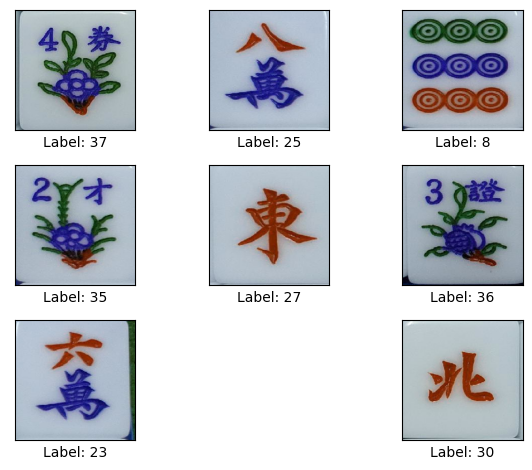

In [25]:
display_image(img_arr, label, 9)

## Tensor model setup

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

### Create base model with Mobilenet V2

In [27]:
#Specifying the include_top=False argument, so that the network doesn't include the classification layers at the top
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')


In [28]:
#Set base_model as not trainable, which prevents the weights in a given layer from being updated during training, to allow extraction of features
base_model.trainable = False

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


### Define classification layer, second last layer (Conv2D), and input processing/ augmentation

In [30]:
#Use tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


In [31]:
#Convert features into a single prediction per image,with 42 classes
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')


In [32]:
#Define data normalization with tf.keras.applications.mobilenet_v2.preprocess_input and data augmentation
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

data_augmentation = tf.keras.Sequential([
  layers.RandomZoom(.2,.2),
  layers.RandomContrast(0.3),
])

In [33]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
print(x.shape)

x = preprocess_input(x)
print(x.shape)

x = base_model(x, training=False)
print(x.shape)

x = global_average_layer(x)
print(x.shape)

outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

(None, 224, 224, 3)
(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)
Output has a dimension of: (None, 42)


## Training the output layer and final layers

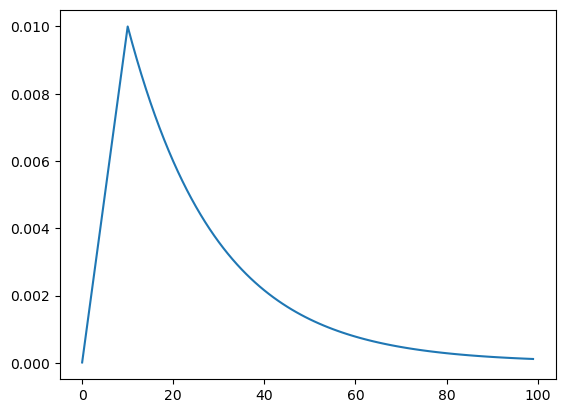

In [34]:
def scheduler(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-2
    LR_MIN = 1e-5
    LR_RAMPUP_EPOCHS = 10
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .95

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN

    return lr
cosine_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=False)
plt.plot([scheduler(x) for x in range(100)]);


In [35]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'] )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

### Model Output Layer Training

In [36]:
#Create checkpoint for callback
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [37]:
#Set batch size to 16 to speed up training
batch_size = 16

In [38]:
total_epochs = 0
acc = []
val_acc = []
loss = []
val_loss = []
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    epochs = 10
    print('Before', total_epochs)
    history = model.fit(train_ds,  
                        validation_data=val_ds,
                        epochs = total_epochs + epochs,
                        initial_epoch= total_epochs,
                        callbacks=[cp_callback]
                        )
    total_epochs += epochs
    print('After', total_epochs)

    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']

    loss += history.history['loss']
    val_loss += history.history['val_loss']

Before 0
Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 3.6521 - accuracy: 0.0952
Epoch 1: saving model to training_1\cp.ckpt
27/27 [==============================] - 22s 572ms/step - loss: 3.6521 - accuracy: 0.0952 - val_loss: 2.8065 - val_accuracy: 0.2429
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 2.0092 - accuracy: 0.4405
Epoch 2: saving model to training_1\cp.ckpt
27/27 [==============================] - 15s 553ms/step - loss: 2.0092 - accuracy: 0.4405 - val_loss: 2.0727 - val_accuracy: 0.3929
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.6405
Epoch 3: saving model to training_1\cp.ckpt
27/27 [==============================] - 13s 484ms/step - loss: 1.4329 - accuracy: 0.6405 - val_loss: 1.7724 - val_accuracy: 0.5000
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.7643
Epoch 4: saving model to training_1\cp.ckpt
27/27 [==============================] - 13

### Model Evaluation

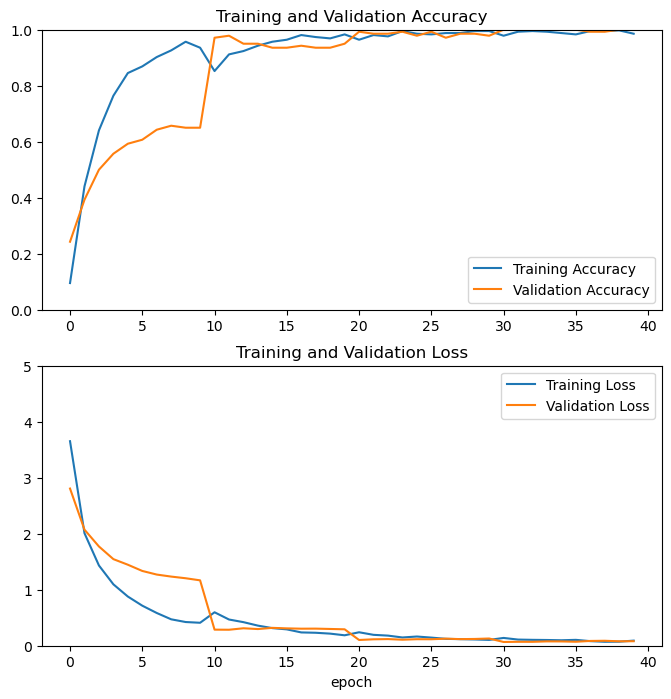

In [39]:
#Learning curve of model training
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([epochs-1,epochs-1])
          #plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([epochs-1,epochs-1])
         #plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Prediction (with test set)

In [40]:
y_pred = model.predict(X_test.astype('f'))
y_pred = np.argmax(y_pred, axis=1)

5/5 [==============================] - 5s 625ms/step


In [41]:
cr = classification_report(y_test, y_pred, output_dict=True)#, target_names=np.argmax(y_true, axis = 1)
print('Macro f1 score:', f1_score(y_test, y_pred, average = 'macro'))
cr_df = pd.DataFrame.from_dict(cr).T
display(cr_df[cr_df['f1-score']<0.5])

Macro f1 score: 0.7745464852607711


precision    recall  f1-score  support
5    0.333333  0.666667  0.444444      3.0
34   0.333333  0.333333  0.333333      3.0
37   0.500000  0.333333  0.400000      3.0
40   0.333333  0.333333  0.333333      3.0

The model performed the worst on label 7, with f1-score of 0, whereas 5,19,34,40 has a f1-score <0.5.

## Base model training

After training the output layer, we will also train the base model.

In [42]:
#Set base model to trainable, and check the number of layers in base model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 90

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [43]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [44]:
#Compile the model again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= base_learning_rate/100),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [45]:
#model.load_weights("training_1/cp.ckpt")

In [46]:
base_tune_epochs = 10
total_epochs = 40
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #place to function too
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    epochs = 10
    print('Before', total_epochs)
    history_base = model.fit(train_ds,  
                            validation_data=val_ds,
                            epochs = total_epochs + base_tune_epochs,
                            initial_epoch= total_epochs,
                            callbacks=[cp_callback]
                            )
    total_epochs += epochs
    print('After', total_epochs)

    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    acc += history_base.history['accuracy']
    val_acc += history_base.history['val_accuracy']

    loss += history_base.history['loss']
    val_loss += history_base.history['val_loss']


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Before 40
Epoch 41/50
27/27 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9905
Epoch 41: saving model to training_2\cp.ckpt
27/27 [==============================] - 30s 780ms/step - loss: 0.0569 - accuracy: 0.9905 - val_loss: 0.0567 - val_accuracy: 0.9786
Epoch 42/50
27/27 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9929
Epoch 42: saving model to training_2\cp.ckpt
27/27 [==============================] - 19s 693ms/step - loss: 0.0389 - accuracy: 0.9929 - val_loss: 0.0551 - val_accuracy: 0.9857
Epoch 43/50
27/27 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9857
Epoch 43: saving model to training_2\cp.ckpt
27/27 [==============================] - 19s 705ms/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0575 - val_accuracy: 0.9857
Epoch 44/50
27/27 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 1.0000
Epoch 44: saving model to training_2\cp.ckpt
27/27 [===========================

### Model Evaluation

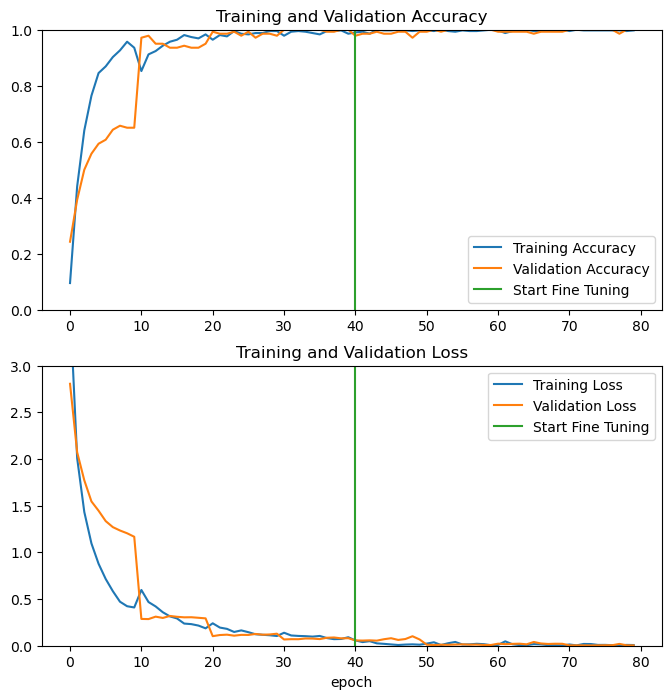

In [48]:
#Learning curve of model training + fine tuning
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([40,40],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([40,40],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
y_pred_base = model.predict(X_test.astype('f'))
y_pred_base = np.argmax(y_pred_base, axis=1)
print('Macro f1 score with base model training:', f1_score(y_test, y_pred_base, average = 'macro'))

5/5 [==============================] - 5s 581ms/step
Macro f1 score with base model training: 0.8482048374905518


The macro f1 score improved from ~0.76 to ~0.85 with tuning of base model.

## Error Analysis

Let's check and see which labels are performing particularly bad.

We will try to find out which labels performed particularly bad by the model, with f1-score < 0.７

In [50]:
cr_base = classification_report(y_test , y_pred_base, output_dict=True)
rpt_base = pd.DataFrame.from_dict(cr_base).T

In [51]:
display(rpt_base[rpt_base['f1-score'] < 0.7])

precision    recall  f1-score  support
5    0.400000  0.666667  0.500000      3.0
7    1.000000  0.333333  0.500000      3.0
20   0.666667  0.666667  0.666667      3.0
34   0.500000  0.333333  0.400000      3.0
36   0.333333  0.666667  0.444444      3.0
37   0.500000  0.333333  0.400000      3.0
38   1.000000  0.500000  0.666667      2.0
40   0.333333  0.333333  0.333333      3.0

Labels 5,13,20,34,36-40 has a f1-score <0.7, let's try to get an insight from the corresponding images from the data set.

In [52]:
# A function to extract the index of worst performing labels
# Extract the worst performing labels and store in a list.
def worst_f1_extract(df, f1_thresold):
    global f1_list
    f1_list = df.iloc[:-3].index[df['f1-score'].iloc[:-3] < f1_thresold].astype("uint8").tolist()
    print('Worst performing labels with f1-scocre <',f1_thresold,'are:', f1_list)
    #Get the corresponding image indices of labels that performed poorly.
    test_df = pd.DataFrame(data = [y_test, indices_test], index =['label', 'index']).T
    test_df = test_df[test_df['label'].isin(f1_list)].sort_values('label')
    #display(test_df)
    return test_df

In [53]:
#Define a function for getting imgage array and label array of input df with label and index
def f1_array (df):
    img_lst_f1 = []
    label_lst_f1 = []
    for index in df['index']:
        img_lst_f1.append(img_arr[index])
    img_arr_f1 = np.array(img_lst_f1, dtype=object)
    print('No. of images in test set  with f1-scocre <',f1_thresold, img_arr_f1.shape[0])
    for index in df['index']:
        label_lst_f1.append(label[index])
    label_arr_f1 = np.array(label_lst_f1, dtype =object)
    num_img = len(img_arr_f1)
    return (img_arr_f1, label_arr_f1, num_img)

In [54]:
f1_thresold = 0.7
lowf1_df = worst_f1_extract(rpt_base, f1_thresold)

Worst performing labels with f1-scocre < 0.7 are: [5, 7, 20, 34, 36, 37, 38, 40]


In [55]:
(f1_img, f1_label, num_img) = f1_array(lowf1_df)

No. of images in test set  with f1-scocre < 0.7 26


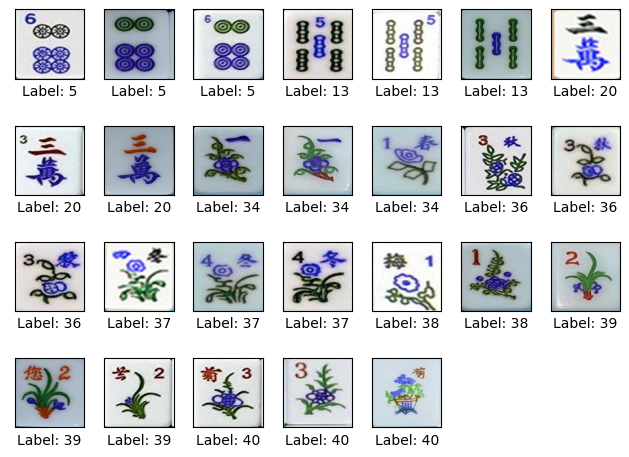

In [56]:
display_image(f1_img, f1_label, num_img)

With reference to the displayed photos, it is noticed that the images of label 34-41 (bonus) could vary significantly, hence affecting the accuracy. Similar observation is found on label 34-41 for all bonuses.</br>
For other labels, it is suspected that the arabic numerals at top left/right corners might have led to the low accuracy. As such, try adding a RandomTranslation layer to images so the upper most part of images would be out of training data.

## Training Model again, with RandomTranslation for data augmentation

In [55]:
#New layer of RandomTranslation added to data, which potentially shift image upward by 20%
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
data_augmentation = tf.keras.Sequential([
  layers.RandomZoom(.2,.2),
  #layers.RandomRotation(0.3),
  #layers.RandomFlip("horizontal_and_vertical"),  
  layers.RandomContrast(0.3),
  layers.RandomTranslation(height_factor = (-0.2,0), width_factor = 0.2, fill_mode = 'nearest')
])

In [56]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [61]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
print(x.shape)

x = preprocess_input(x)
print(x.shape)

x = base_model(x, training=False)
print(x.shape)

x = global_average_layer(x)
print(x.shape)

outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

(None, 224, 224, 3)
(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)
Output has a dimension of: (None, 42)


In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate/100),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'] )
model.load_weights("training_2/cp.ckpt")
model.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [63]:
batch_size = 16
acc_3 = []
val_acc_3 = []
loss_3 = []
val_loss_3 = []
total_epochs = 80
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    epochs = 5
    print('Before', total_epochs)
    history_3 = model.fit(train_ds,  
                             validation_data=val_ds,
                             epochs = total_epochs + epochs,
                             initial_epoch= total_epochs,
                             callbacks=[cp_callback]
                                )
    total_epochs += epochs
    print('After', total_epochs)
#    else:
#        history = model.fit(train_ds,  
 #                           validation_data=test_ds,
 #                           epochs = epochs,
  #                          initial_epoch=history.epoch[-1]
#    )
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    acc_3 += history_3.history['accuracy']
    val_acc_3 += history_3.history['val_accuracy']

    loss_3 += history_3.history['loss']
    val_loss_3 += history_3.history['val_loss']

Before 80
Epoch 81/85
27/27 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9810
Epoch 81: saving model to training_3\cp.ckpt
27/27 [==============================] - 35s 774ms/step - loss: 0.0659 - accuracy: 0.9810 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 82/85
27/27 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9667
Epoch 82: saving model to training_3\cp.ckpt
27/27 [==============================] - 20s 758ms/step - loss: 0.0870 - accuracy: 0.9667 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 83/85
27/27 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9833
Epoch 83: saving model to training_3\cp.ckpt
27/27 [==============================] - 20s 742ms/step - loss: 0.0728 - accuracy: 0.9833 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 84/85
27/27 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9905
Epoch 84: saving model to training_3\cp.ckpt
27/27 [===========================

In [64]:
y_pred_3 = model.predict(X_test.astype('f'))
y_pred_3 = np.argmax(y_pred_3, axis=1)
print('Macro f1 score with base model training:', f1_score(y_test, y_pred_3, average = 'macro'))

5/5 [==============================] - 5s 623ms/step
Macro f1 score with base model training: 0.8577097505668932


No significant change observed after introducing RandomTranslation.</br>
Let's further investigate on the worst performing labels from previous model.

## Error analysis with tuned base model

Now, we would display all images of labels that didn't perform perfectly, and see if any insights could be gained from our dataset.

In [65]:
#Get label and index of those having f1-score <1
f1_thresold = 1
lowf1_tune = worst_f1_extract(rpt_base, f1_thresold)
lowf1_tune

Worst performing labels with f1-scocre < 1 are: [4, 5, 6, 7, 9, 11, 12, 13, 14, 17, 19, 20, 22, 25, 28, 29, 34, 36, 37, 38, 40]


label  index
75       4     57
18       4    439
39       4    333
136      5    420
94       5     60
..     ...    ...
55      38    308
38      38    679
99      40    546
131     40    440
9       40    504

[69 rows x 2 columns]

In [66]:
#Define a new function to display all images from a label
def display_image_label(label):
    img_arr_withlabel = []
    img_index = mj_df.index[mj_df['label'] == label]
    print(img_index)
    for i in img_index:
        img_arr_withlabel.append(img_arr[i])
    label_arr = np.full(len(img_index), label)
    display_image(img_arr_withlabel, label_arr, len(label_arr))

Int64Index([57, 76, 86, 90, 168, 183, 228, 283, 333, 361, 403, 439, 490, 528,
            570, 615, 660],
           dtype='int64')


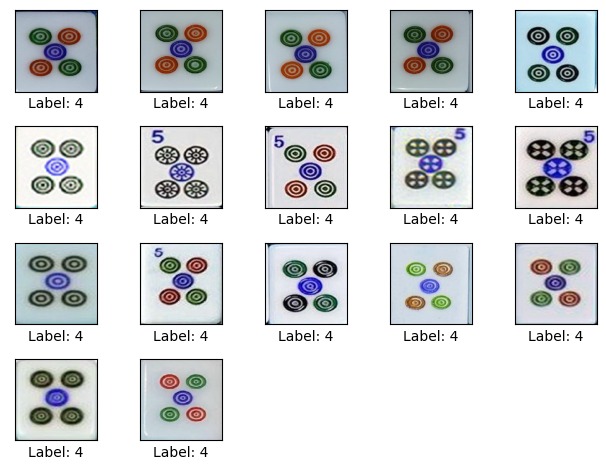

Int64Index([ 26,  47,  60, 111, 167, 196, 238, 280, 332, 358, 400, 420, 487,
            525, 567, 612, 661],
           dtype='int64')


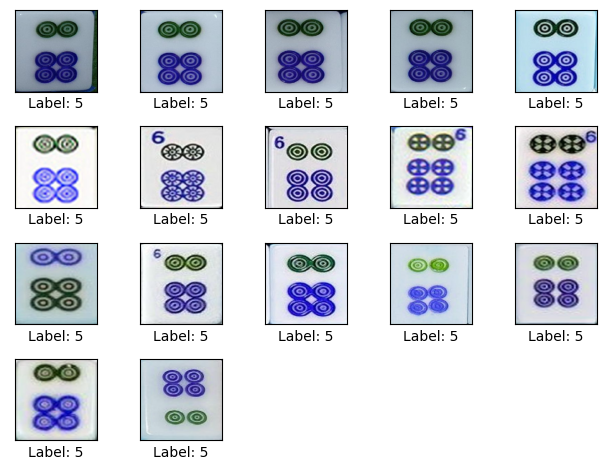

Int64Index([ 25,  45,  89, 101, 166, 192, 250, 277, 331, 355, 397, 421, 484,
            522, 564, 609, 628, 662],
           dtype='int64')


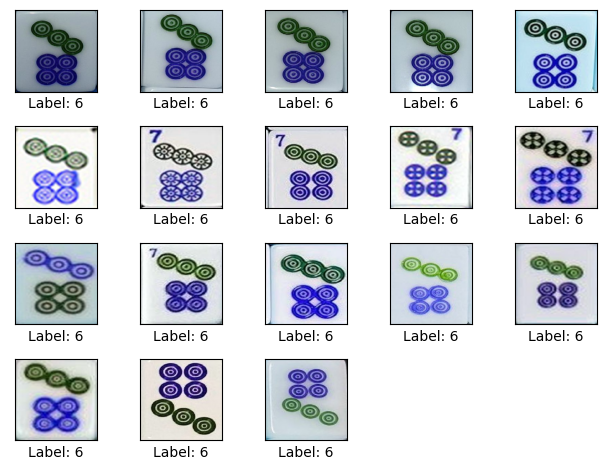

Int64Index([75, 129, 165, 188, 239, 274, 330, 349, 352, 393, 422, 481, 519,
            561, 606, 663],
           dtype='int64')


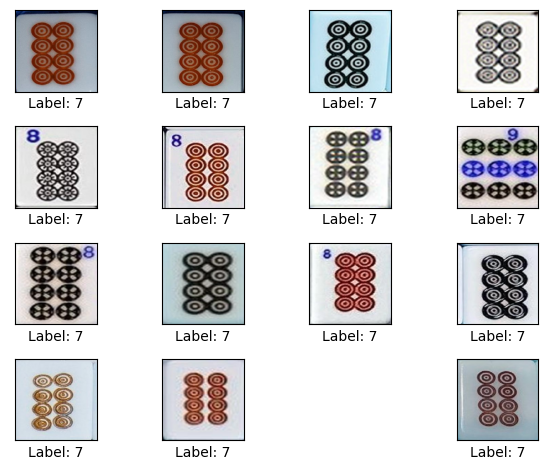

Int64Index([ 31,  51,  64,  73, 163, 199, 259, 294, 304, 372, 414, 452, 501,
            539, 581, 626, 643, 665, 676, 677],
           dtype='int64')


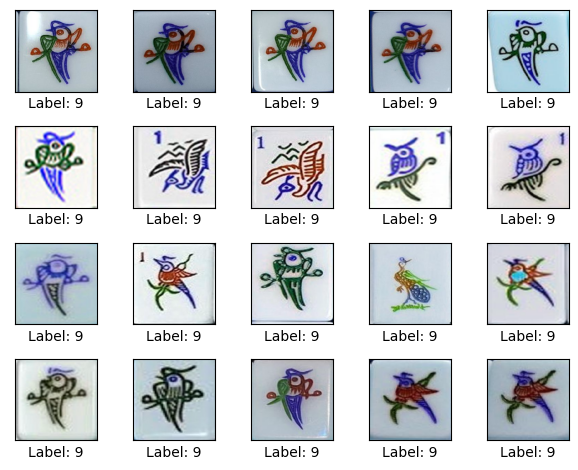

Int64Index([ 29,  54,  77, 133, 161, 191, 243, 288, 298, 366, 408, 458, 495,
            533, 575, 620, 667],
           dtype='int64')


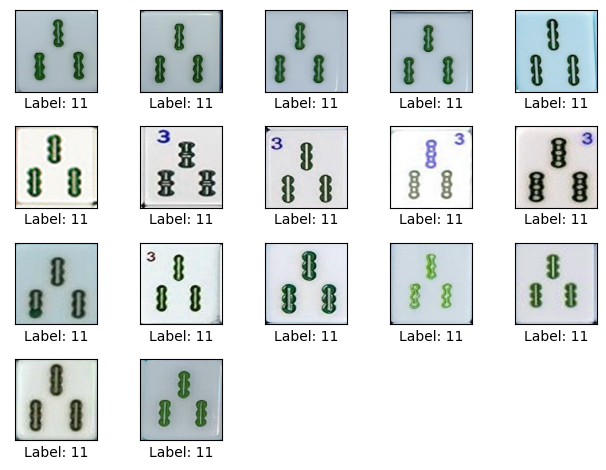

Int64Index([ 69,  70,  87, 117, 160, 187, 241, 285, 297, 363, 405, 459, 492,
            530, 572, 617, 668],
           dtype='int64')


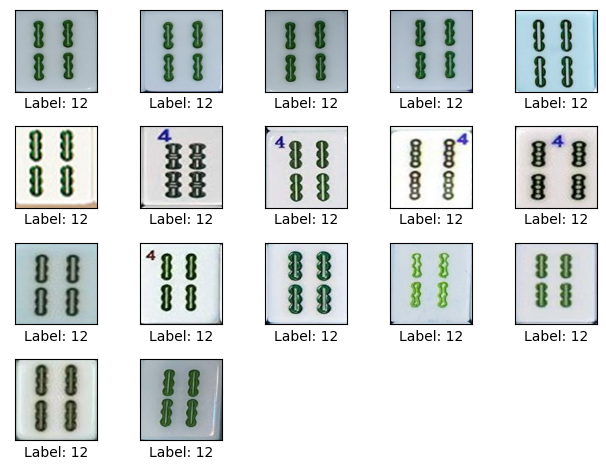

Int64Index([ 95,  97, 105, 134, 159, 186, 233, 282, 302, 360, 402, 460, 489,
            527, 569, 614, 669],
           dtype='int64')


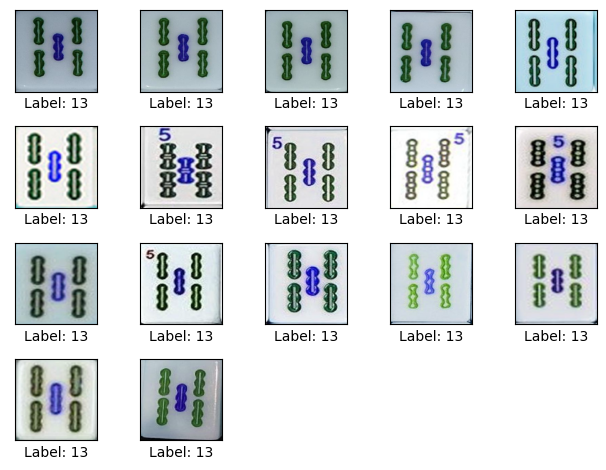

Int64Index([ 59,  72,  79, 100, 158, 198, 230, 279, 301, 357, 399, 447, 486,
            524, 566, 611, 670],
           dtype='int64')


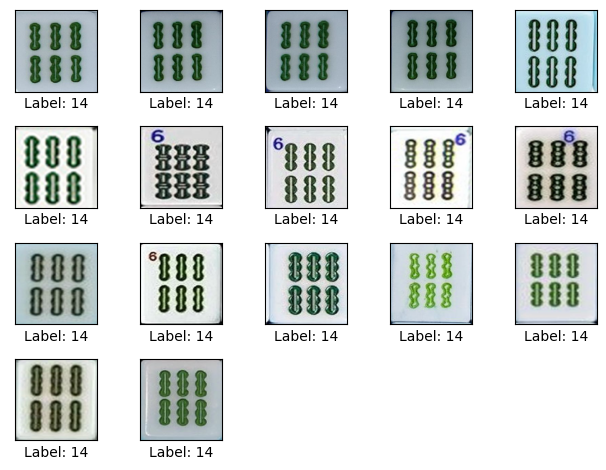

Int64Index([ 83,  85, 107, 120, 155, 185, 255, 270, 296, 348, 390, 450, 477,
            515, 557, 602, 673],
           dtype='int64')


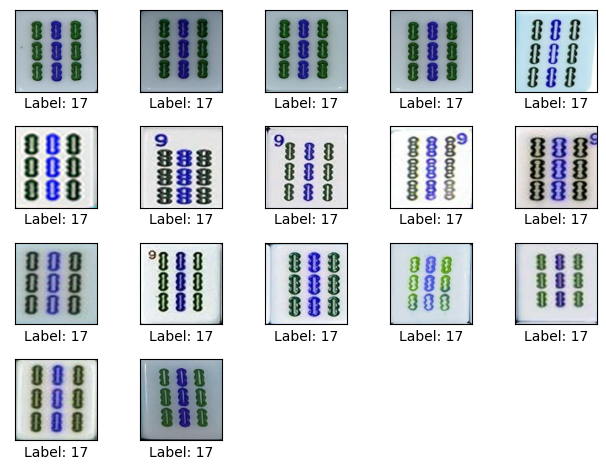

Int64Index([ 10,  65,  88, 106, 180, 217, 234, 290, 327, 368, 410, 453, 497,
            535, 577, 622, 648],
           dtype='int64')


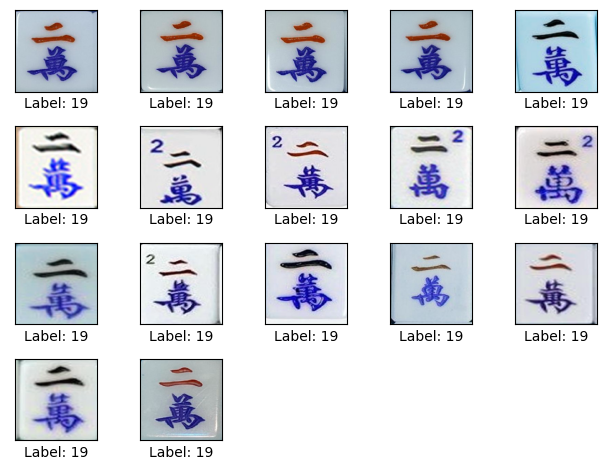

Int64Index([48, 82, 84, 179, 213, 245, 287, 326, 365, 407, 454, 494, 532, 574,
            619, 649],
           dtype='int64')


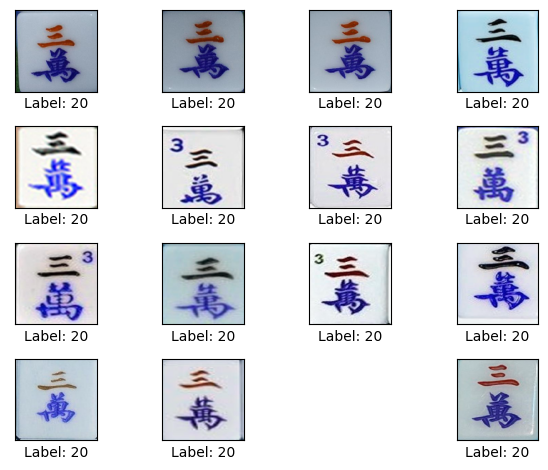

Int64Index([ 13,  21,  42, 118, 177, 222, 235, 281, 324, 359, 401, 456, 488,
            526, 568, 613, 651],
           dtype='int64')


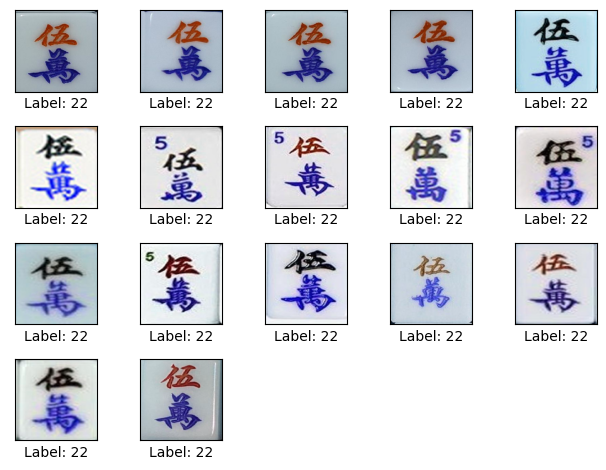

Int64Index([  1,  11,  39, 132, 174, 212, 236, 272, 321, 350, 392, 445, 479,
            517, 559, 604, 654, 678],
           dtype='int64')


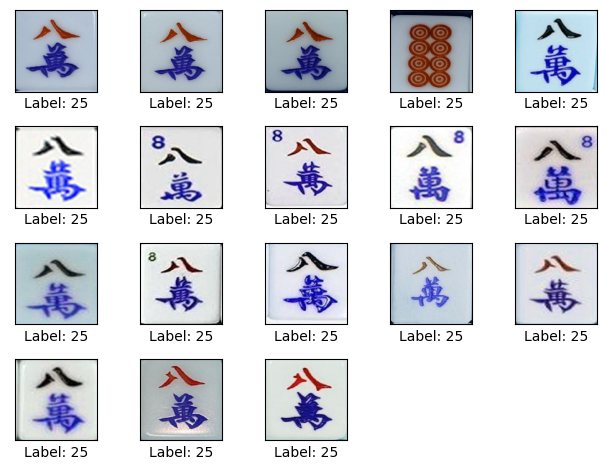

Int64Index([ 19,  23,  81, 110, 145, 215, 232, 266, 318, 345, 384, 433, 471,
            509, 551, 596, 640, 697],
           dtype='int64')


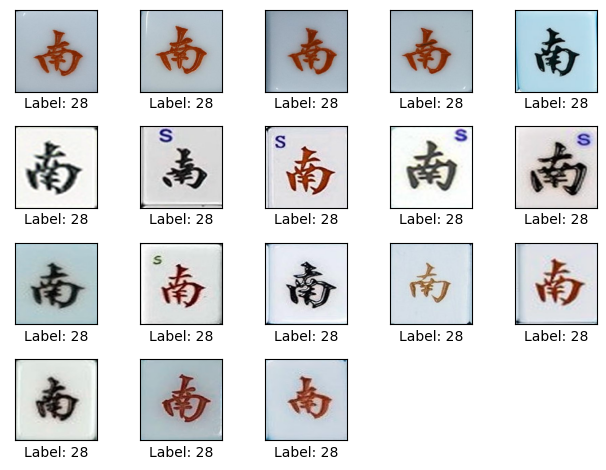

Int64Index([  9,  37,  67,  98, 144, 211, 257, 267, 317, 344, 386, 434, 473,
            511, 550, 598, 641, 698],
           dtype='int64')


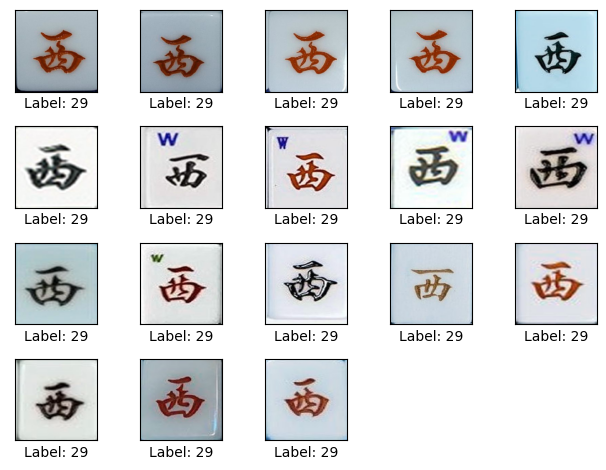

Int64Index([135, 154, 210, 256, 260, 312, 340, 381, 426, 468, 544, 589, 638,
            683],
           dtype='int64')


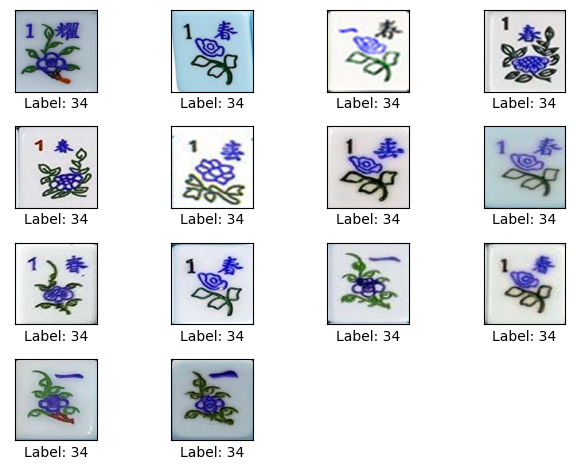

Int64Index([5, 152, 208, 252, 262, 310, 341, 379, 424, 466, 542, 587, 636, 685,
            691],
           dtype='int64')


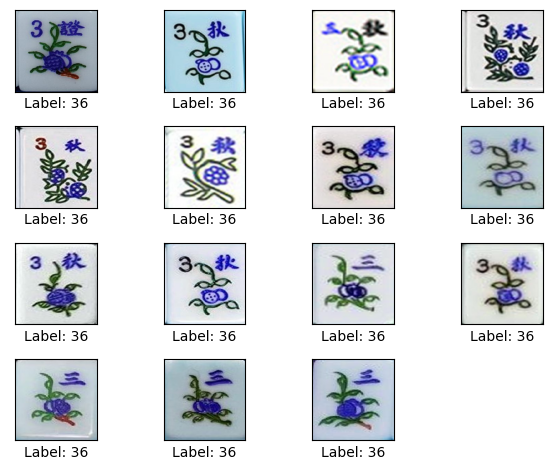

Int64Index([0, 151, 207, 251, 263, 309, 343, 378, 419, 465, 541, 586, 629, 635,
            686, 692],
           dtype='int64')


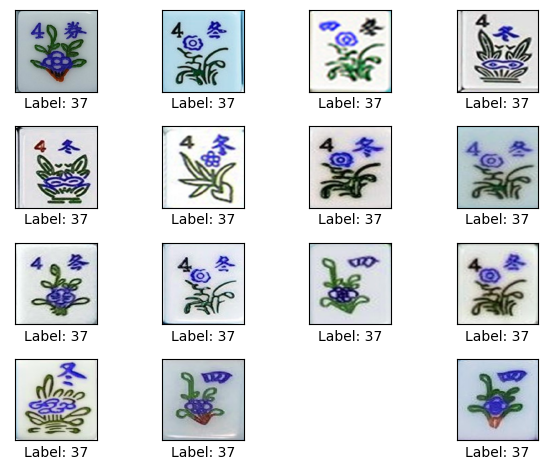

Int64Index([36, 150, 203, 308, 377, 442, 464, 506, 548, 593, 634, 679], dtype='int64')


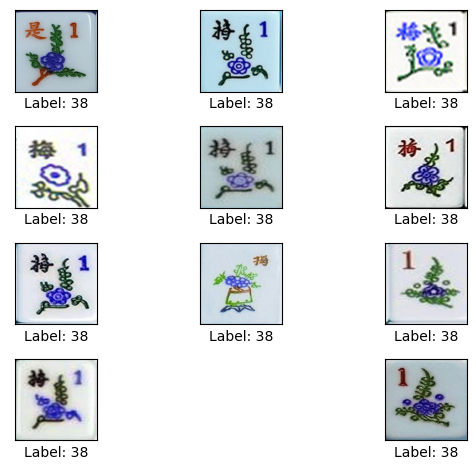

Int64Index([33, 147, 201, 306, 375, 440, 462, 504, 546, 591, 632, 681, 688], dtype='int64')


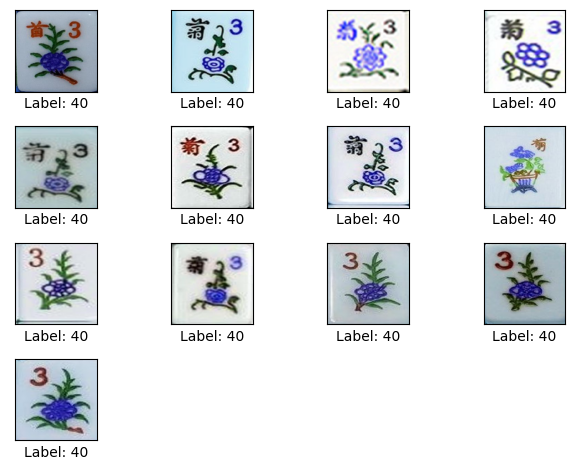

In [67]:
#Display all images of labels we got in f1_list, which is obtained from the function worst_f1_extract
for i in f1_list:
    display_image_label(i)

Several observations here:

1.Some of the images are rotated by 180 degree, including: </br>
a. Label 5: index 661 </br>
b. Label 6: index 628, 662

2.Some have a wrong label: </br>
a. Index 349: Label 8 instead of 7 </br>
b. Index 132: Label 7 instead of 25

So we will try to fix this with: </br>
1.Rotate the images by 180 degrees</br>
2.Fix the labels in mj_df


### Rotate the images by 180 degrees

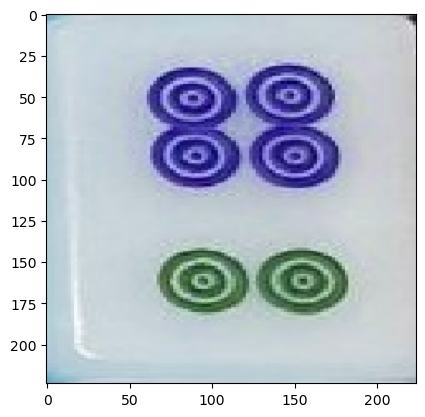

In [68]:
plt.imshow(img_arr[661].astype("uint8"))

In [69]:
img_arr[628] = img_arr[628][::-1,::-1]
img_arr[661] = img_arr[661][::-1,::-1]
img_arr[662] = img_arr[662][::-1,::-1]

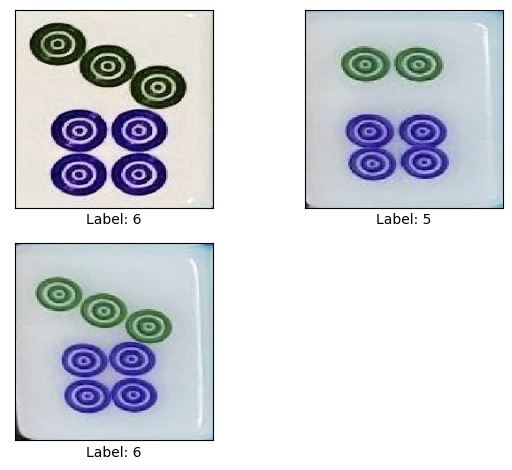

In [70]:
display_image(np.array([img_arr[628],img_arr[661],img_arr[662]]),np.array([label[628],label[661],label[662]]), 3)

### Revise the labels

In [71]:
mj_df.loc[349,['label', 'label_name']] = [8, 'dots-9']
mj_df.loc[132,['label', 'label_name']] = [7, 'dots-8']

In [72]:
mj_df.loc[[132,349]]

image_name  label label_name      image_path  width  height  ratio
132    133.jpg      7     dots-8  images\133.jpg  240.0   320.0   0.75
349    350.jpg      8     dots-9  images\350.jpg  240.0   320.0   0.75

### Split the dataset again to reflect the above changes

Train test 1 has a size of (420, 224, 224, 3)
Train test 2 has a size of (420, 224, 224, 3)
Train test 3 has a size of (420, 224, 224, 3)
Train test 4 has a size of (420, 224, 224, 3)


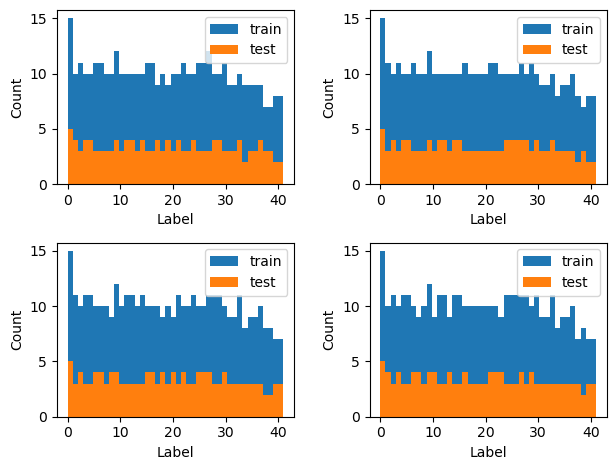

In [73]:
label = np.array(mj_df['label'])
kfold_bar=[]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=320)
fig = plt.figure()
n=0
indices_train, indices_test = train_test_split(indices, test_size=0.2, random_state=320, stratify=label)
img_train, X_test = img_arr[indices_train], img_arr[indices_test]
label_train, y_test = label[indices_train], label[indices_test]
for train_index, val_index in skf.split(img_train, label_train):
    X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
    y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                     tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
    n += 1
    print('Train test', n, 'has a size of', X_train.shape)
    fig.tight_layout()
    plt.subplot(2, 2, n)
    plt.hist(label_train[train_index], label="train", bins = num_classes)
    plt.hist(label_train[val_index], label="test", bins = num_classes)
    plt.ylabel('Count')
    plt.xlabel('Label')
    plt.legend(loc=1)

## Training with dropout

To further remedy the overfitting, we will introduce dropout to training. A loop with dropout of 0.1 to 0.5 would be constructed, and see which % of dropout generates the best preditions.

In [74]:
checkpoint_path = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [75]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
print(x.shape)
x = preprocess_input(x)
print(x.shape)
x = base_model(x, training=False)
print(x.shape)
x = global_average_layer(x)
print(x.shape)

outputs = prediction_layer(x)

print('Output has a dimension of: ' + str(outputs.shape))
model = tf.keras.Model(inputs, outputs)

(None, 224, 224, 3)
(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)
Output has a dimension of: (None, 42)


In [76]:
batch_size = 16
acc_drop = []
val_acc_drop = []
loss_drop = []
val_loss_drop = []
acc_performance = []
loss_performance = []
y_pred_drop_lst = []

for dropout_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate/100),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'] )
    model.load_weights("training_3/cp.ckpt")

    total_epochs = 100
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(f"weights-{dropout_rate}.hdf5", save_best_only=True, save_weights_only=True)
    for train_index, val_index in skf.split(img_train, label_train):
        X_train, X_val = img_train[train_index].astype('f'), img_train[val_index].astype('f')
        y_train, y_val = tf.keras.utils.to_categorical(label_train[train_index], num_classes=None, dtype='float32'),\
                         tf.keras.utils.to_categorical(label_train[val_index], num_classes=None, dtype='float32')
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
        train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #place to function too
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

        epochs = 5
        print('Before', total_epochs)
        history_drop = model.fit(train_ds,  
                                 validation_data=val_ds,
                                 epochs = total_epochs + epochs,
                                 initial_epoch= total_epochs,
                                 callbacks=[cp_callback]
                                    )
        total_epochs += epochs
        print('After', total_epochs)

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        acc_drop += history_drop.history['accuracy']
        val_acc_drop += history_drop.history['val_accuracy']
        acc_tuple = (dropout_rate, acc_drop,val_acc_drop)
        acc_performance.append(acc_tuple)

        loss_drop += history_drop.history['loss']
        val_loss_drop += history_drop.history['val_loss']
        loss_tuple = (dropout_rate, loss_drop,val_loss_drop)
        loss_performance.append(loss_tuple)
    
    y_pred_drop = model.predict(X_test.astype('f'))
    y_pred_drop = np.argmax(y_pred_drop, axis=1)
    perform_tuple = dropout_rate, y_pred_drop
    y_pred_drop_lst.append(perform_tuple)

Before 100
Epoch 101/105
27/27 [==============================] - 38s 779ms/step - loss: 0.0312 - accuracy: 0.9905 - val_loss: 0.1002 - val_accuracy: 0.9929
Epoch 102/105
27/27 [==============================] - 19s 707ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 0.0907 - val_accuracy: 0.9929
Epoch 103/105
27/27 [==============================] - 21s 773ms/step - loss: 0.0373 - accuracy: 0.9857 - val_loss: 0.1035 - val_accuracy: 0.9857
Epoch 104/105
27/27 [==============================] - 20s 757ms/step - loss: 0.0432 - accuracy: 0.9881 - val_loss: 0.0701 - val_accuracy: 0.9929
Epoch 105/105
27/27 [==============================] - 19s 708ms/step - loss: 0.0294 - accuracy: 0.9952 - val_loss: 0.0599 - val_accuracy: 0.9929
After 105
Before 105
Epoch 106/110
27/27 [==============================] - 19s 696ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.0106 - val_accuracy: 0.9929
Epoch 107/110
27/27 [==============================] - 19s 690ms/step - loss: 0.0171 - accur

In [77]:
for item in y_pred_drop_lst:
    print('Macro f1 score with dropout of',item[0], f1_score(y_test, item[1], average = 'macro'))

Macro f1 score with dropout of 0.1 0.8849395313681028
Macro f1 score with dropout of 0.2 0.8982237339380196
Macro f1 score with dropout of 0.3 0.8850529100529101
Macro f1 score with dropout of 0.4 0.8550075585789872
Macro f1 score with dropout of 0.5 0.8790816326530612


Model performed the best with dropout of 0.2 and 0.3, with f1 score of 0.90/0.89. At last, we will further test for the best dropout.

### Error analysis of final model

Finally, error analysis on model with dropout of 0.2.

In [88]:
y_pred_drop_lst[1]

(0.2,
 array([ 8,  0, 17, 30, 23,  0, 25, 36,  2, 22, 28, 30, 28,  6, 36, 15, 35,
        16,  4, 14, 24, 19, 39, 33, 39, 20, 41, 33, 37, 26, 13, 39, 21, 29,
        35, 30, 41, 27, 38,  4,  9, 11, 24, 24, 20, 34, 14, 29, 17, 22, 22,
         9, 20, 27,  7, 40, 12, 23, 12,  6, 12, 30,  6, 15, 18,  0, 32, 15,
        23,  3,  8, 33, 33, 37,  6,  4,  1, 10, 27, 23,  3, 31, 26, 29,  1,
        22, 26,  3, 17, 29, 35,  9,  7, 31,  5,  0, 19,  0, 22, 40,  6, 36,
        14, 28,  8, 18, 10, 25, 17, 27, 19, 10,  7, 36, 11,  8, 34, 11, 37,
        20, 13, 32, 13, 16, 32,  2, 35,  1, 18, 31, 12, 35, 16, 18,  2, 25,
         5, 29, 21, 41], dtype=int64))

In [89]:
y_pred_drop2 = y_pred_drop_lst[1][1]

In [90]:
cr_drop = classification_report(y_test , y_pred_drop2, output_dict=True)
rpt_drop = pd.DataFrame.from_dict(cr_drop).T
rpt_drop

precision    recall  f1-score     support
0              1.000000  1.000000  1.000000    5.000000
1              1.000000  1.000000  1.000000    3.000000
2              1.000000  1.000000  1.000000    3.000000
3              1.000000  1.000000  1.000000    3.000000
4              1.000000  1.000000  1.000000    3.000000
5              1.000000  0.666667  0.800000    3.000000
6              0.800000  1.000000  0.888889    4.000000
7              1.000000  1.000000  1.000000    3.000000
8              1.000000  1.000000  1.000000    4.000000
9              1.000000  0.750000  0.857143    4.000000
10             1.000000  1.000000  1.000000    3.000000
11             1.000000  1.000000  1.000000    3.000000
12             0.750000  1.000000  0.857143    3.000000
13             1.000000  0.750000  0.857143    4.000000
14             1.000000  1.000000  1.000000    3.000000
15             1.000000  1.000000  1.000000    3.000000
16             1.000000  1.000000  1.000000    3.000000
17             1.000000  1.000000  1.000000    4.000000
18             1.000000  1.000000  1.000000    4.000000
19             1.000000  0.750000  0.857143    4.000000
20             0.750000  1.000000  0.857143    3.000000
21             1.000000  0.666667  0.800000    3.000000
22             0.600000  1.000000  0.750000    3.000000
23             1.000000  1.000000  1.000000    4.000000
24             1.000000  1.000000  1.000000    3.000000
25             1.000000  1.000000  1.000000    3.000000
26             1.000000  1.000000  1.000000    3.000000
27             1.000000  1.000000  1.000000    4.000000
28             1.000000  0.750000  0.857143    4.000000
29             0.800000  1.000000  0.888889    4.000000
30             1.000000  1.000000  1.000000    4.000000
31             1.000000  1.000000  1.000000    3.000000
32             1.000000  1.000000  1.000000    3.000000
33             1.000000  1.000000  1.000000    4.000000
34             0.500000  0.333333  0.400000    3.000000
35             0.600000  1.000000  0.750000    3.000000
36             0.500000  0.666667  0.571429    3.000000
37             0.666667  0.666667  0.666667    3.000000
38             1.000000  0.500000  0.666667    2.000000
39             1.000000  1.000000  1.000000    3.000000
40             0.500000  0.333333  0.400000    3.000000
41             1.000000  1.000000  1.000000    3.000000
accuracy       0.907143  0.907143  0.907143    0.907143
macro avg      0.915873  0.900794  0.898224  140.000000
weighted avg   0.921429  0.907143  0.905113  140.000000

In [94]:
#Get label and index of those having f1-score <0.8
f1_thresold = 0.8
lowf1_drop = worst_f1_extract(rpt_drop, f1_thresold)
lowf1_drop

Worst performing labels with f1-scocre < 0.8 are: [22, 34, 35, 36, 37, 38, 40]


label  index
50      22    177
85      22    568
98      22    222
7       34    683
113     34    638
45      34    381
34      35    690
126     35    543
90      35    467
116     36    262
14      36    341
101     36    587
16      37    207
28      37    378
73      37    343
55      38    308
38      38    679
9       40    504
99      40    546
131     40    440

In [95]:
(f1_img, f1_label, num_img) = f1_array(lowf1_drop)

No. of images in test set  with f1-scocre < 0.8 20


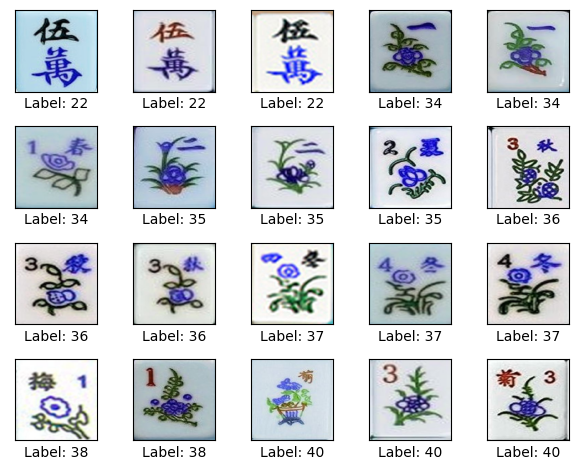

In [96]:
display_image(f1_img, f1_label, num_img)

Only label 22, 34, 35, 36, 37, 38, 40 have a f1-score <0.8. With reference to the images, all the labels look quite different except label 5, leading to inaccurate prediction by the model.

## Conclusion

The tuned Mobilenet_V2 model with trained output layer of GlobalAveragePooling2D demonstrated its ability to classify mahjong class, with accuracy ~0.9 on test set. The image dataset has a relatively small size of 700 images and 42 classes, which could lead to insufficient data for training, even with data augmentation. It is noticed that honours (label 34-41) varies significantly between tiles, which may have led to the inaccurate predictions.

The model accuracy on test set has further improved after dropout was introduced, from ~0.86 to ~0.9. 

To further improved the accuracy of model, a larger data set, especially on honours (label 34-41) shall be required.